In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
cdata = torchvision.datasets.CIFAR10(root = 'cifar10', download = True)
print(cdata)

100%|██████████| 170498071/170498071 [00:13<00:00, 12993219.11it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


In [3]:
# shape of the dataset
print(cdata.data.shape)

# the unique catergories
print(cdata.classes)

# targets is a list of targets converted to ints
print(len(cdata.targets))

(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
50000


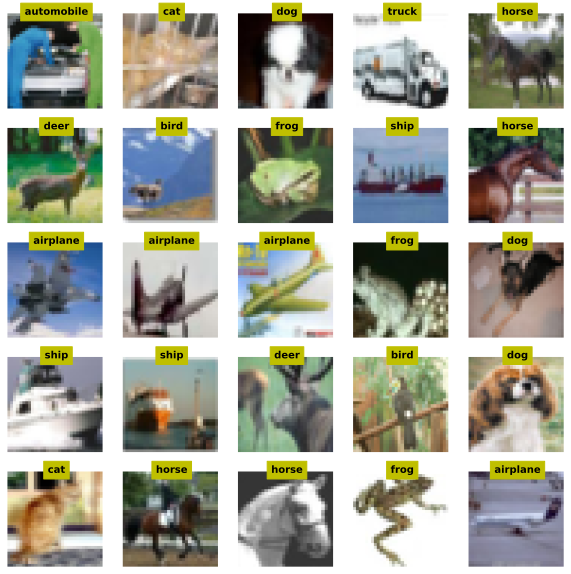

In [4]:
# inspect few random images
fig,axs = plt.subplots(5,5, figsize = (10, 10))

for ax in axs.flatten():

    # select a random picture
    randidx = np.random.choice(len(cdata.targets))

    # extract the image
    pic = cdata.data[randidx, :, :, :]
    label = cdata.classes[cdata.targets[randidx]]

    ax.imshow(pic)
    ax.text(16, 0,
            label, ha = 'center',
            fontweight = 'bold',
            color = 'k', backgroundcolor = 'y')
    ax.axis('off')

In [5]:
# converting the data into tensors
data = torch.tensor(cdata.data)
labels = torch.tensor(cdata.targets)
data = data.permute(0, 3, 2, 1)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda', index=0)

In [8]:
# normalizing the data
dataNorm = data/torch.max(data)
dataNorm = dataNorm.to(device)
labels = labels.to(device)


In [9]:
# splitting the data into train, dev and test sets
train_data, td_data, train_labels, td_labels = train_test_split(dataNorm, labels, test_size = 2000)
dev_data, test_data, dev_labels, test_labels = train_test_split(td_data, td_labels, test_size = .5)

# converting it into tensor dataset
train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)

# converting the dataset into dataloader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
dev_loader = DataLoader(dev_dataset, batch_size = len(dev_dataset))
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))

In [56]:


def makeTheNet():

    class cifarnet(nn.Module):

        def __init__(self):
            super().__init__()

            # conv BLOCK 1
            self.conv1 = nn.Conv2d(3, 16, 5, padding = 2)
            self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
            self.bn1 = nn.BatchNorm2d(32)

            # img size = (14, 14)
            # conv BLOCK 2
            self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
            self.bn2 = nn.BatchNorm2d(64)

            # img size = (7, 7)
            # conv BLOCK 3
            self.conv4 = nn.Conv2d(64, 128, 3,padding = 1)
            self.bn3 = nn.BatchNorm2d(128)

            # linear layers
            self.fc1 = nn.Linear(128*4*4, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 10)



        def forward(self, x):

            x = F.max_pool2d(self.conv2(self.conv1(x)), 2)
            x = F.leaky_relu(self.bn1(x))

            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bn2(x))

            x =  F.max_pool2d(self.conv4(x), 2)
            # x = F.leaky_relu(self.bn3(x))
            x =F.leaky_relu(self.bn3(x))

            nUnits = (x.shape.numel()/x.shape[0])
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))
            x = F.dropout(x, p = 0.5, training = self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p = 0.5, training = self.training)
            x = self.fc3(x)


            return x

    net = cifarnet()
    net.to(device)

    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer





In [57]:
net, lossfun, optimzier = makeTheNet()
X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now lets compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(' ')
print('Loss')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss
tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)


In [58]:
from torchsummary import summary

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
            Conv2d-2           [-1, 32, 32, 32]           4,640
       BatchNorm2d-3           [-1, 32, 16, 16]              64
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
            Conv2d-6            [-1, 128, 8, 8]          73,856
       BatchNorm2d-7            [-1, 128, 4, 4]             256
            Linear-8                  [-1, 128]         262,272
            Linear-9                   [-1, 64]           8,256
           Linear-10                   [-1, 10]             650
Total params: 369,834
Trainable params: 369,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.67
Params size (MB): 1.41
Estimated T

In [59]:
dataNorm.device

device(type='cuda', index=0)

In [60]:
def function2trainTheModel():

    # number of epochs
    numepochs = 50

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # send the model to the GPu
    net.to(device)

    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)
            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())


        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100*np.mean(batchAcc)


        # test performance
        net.eval()
        X, y = next(iter(dev_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            devLoss[epochi] = loss.item()
            devAcc[epochi] = 100*(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())

        if epochi % 5 == 0:
            print(f'Epoch: {epochi}/{numepochs}, Train Accuracy: {trainAcc[epochi]}, Devset Accuracy: {devAcc[epochi]}')

    return trainLoss, devLoss, trainAcc, devAcc, net





In [61]:

trainLoss, devLoss, trainAcc, devAcc, net = function2trainTheModel()

Epoch: 0/50, Train Accuracy: 40.48125076293945, Devset Accuracy: 58.20000076293945
Epoch: 5/50, Train Accuracy: 74.02083587646484, Devset Accuracy: 75.19999694824219
Epoch: 10/50, Train Accuracy: 81.59375, Devset Accuracy: 78.0999984741211
Epoch: 15/50, Train Accuracy: 86.04166412353516, Devset Accuracy: 78.69999694824219
Epoch: 20/50, Train Accuracy: 88.80208587646484, Devset Accuracy: 78.79999542236328
Epoch: 25/50, Train Accuracy: 90.62083435058594, Devset Accuracy: 79.79999542236328
Epoch: 30/50, Train Accuracy: 92.05208587646484, Devset Accuracy: 80.19999694824219
Epoch: 35/50, Train Accuracy: 93.2750015258789, Devset Accuracy: 79.79999542236328
Epoch: 40/50, Train Accuracy: 93.98332977294922, Devset Accuracy: 78.0999984741211
Epoch: 45/50, Train Accuracy: 94.83125305175781, Devset Accuracy: 80.69999694824219


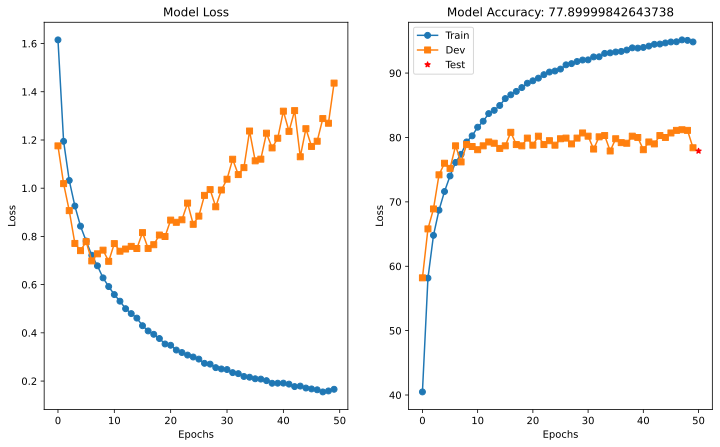

In [62]:
net.eval()
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

with torch.inference_mode():
    yHat = net(X)
    loss = lossfun(yHat, y)
    testLoss = loss.item()
    testAcc = 100*(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())

fig, ax = plt.subplots(1,2 , figsize = (12, 7))

ax[0].plot(trainLoss, 'o-', label = 'Train')
ax[0].plot(devLoss, 's-', label = 'Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Model Loss')

ax[1].plot(trainAcc, 'o-', label = 'Train')
ax[1].plot(devAcc, 's-', label = 'Dev')
ax[1].plot(50, testAcc, 'r*', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Model Accuracy: {testAcc}')

plt.legend()
plt.show()